In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from scipy.optimize import minimize
from Nexis_functions import heatmap, total_tau_plot, normalize_by_l2_norm, mse_matrix
from functools import partial
from Nexis_model_inverse import run_Nexis

## Preparing Inputs

In [2]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix.csv')

# List of striatal regions to exclude from further analysis 
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix (divide by max because min is already 0 in diagonal entries)
max_value = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max_value

In [4]:
# Define the number of regions  
nROI = 86 - len(regions_to_exclude)

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Converting region order of DK to that of connectivity matrix
new_order_DK = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order_DK, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

In [5]:
# Define inputs to Nexis

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
U_ = np.zeros((nROI, 1)) # Cell type matrix (nROI x nTypes)/ gene_data_reordered
t_vec_ = np.linspace(0, 15, 16)  # Time vector in terms of stages outputted by EBM (16 stages)
w_dir_ = 0  # Since I don't care about directionality, set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
parameters = [0.26578466302222054, 0.4901505014988503, 1.0, 0.5, 0.0, 0.07] # ENTER FIXED PARAMETERS HERE (alpha, beta, gamma, s, b, p)

## Load Patient Data

In [46]:
# Upload subject data
subject_data = pandas.read_csv('Cross-sectional stage and regional tau.csv')

RID = 21 #EDIT PATIENT RID MANUALLY HERE
subject = subject_data[subject_data['RID'] == RID] 

# Define number of time points 
num_time_points = subject.shape[0]

# Define list with stage assingments for each time point
stages = subject['ml_stage'].tolist() 
stages = [int(x) for x in stages] 
#time_point = np.array(stages) 
time_point = 2.5
# LATER: DEFINE IN TERMS OF TIME WHERE TIME vs. STAGE RELAITONSHIP IS SIGNMOIDAL

# Define patient tau data
subject_tau = subject.iloc[:,3:]

# Reorder regions to match region order of connectivity matrix
new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
subject_tau = subject_tau.iloc[:, new_order_ADNI]

# Delete striatal regions 
subject_tau = subject_tau.drop(regions_to_exclude, axis = 1)

# Convert to array and transpose so dim = nROI x # of stages
subject_tau = subject_tau.to_numpy()
subject_tau = subject_tau.T

## Running Inverse Nexis

In [47]:
# Set tau_threshold to percentile under which regional tau is sent to 0
tau_threshold = 50

# Set eigen_threshold to percentile over which eigen values are removed
eigen_threshold = 100

# Initialize run_Nexis class 
nexis_model = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_,
                        region_volumes_=region_volumes_, parameters_=parameters)

# Call the simulate_nexis method with the parameters
x0_inverse = nexis_model.inverse_nexis(time_point, subject_tau, tau_threshold, eigen_threshold)
x0_inverse = x0_inverse.flatten()

# Print resulting matrix (nROI x # of time points)
print(x0_inverse)

[0.         0.         0.62985461 1.15678862 0.         0.
 0.         0.62406668 1.03868509 0.         0.         0.
 0.         0.41275443 0.79975876 0.4346033  0.         0.
 0.43685092 0.         0.42724925 0.44503335 0.49490331 0.
 0.57235692 0.         0.         0.         0.         0.41702596
 0.         0.         0.         0.         0.42948708 0.
 0.         0.         0.         0.         0.4373372  0.65429442
 0.         0.4161049  0.64802486 0.         0.         0.47624094
 0.77902238 0.5305667  0.53228045 0.55259515 0.46200334 0.48509985
 0.50164864 0.52215299 0.         0.64625491 0.60233919 0.
 0.         0.45288573 0.43813729 0.49181594 0.         0.
 0.         0.42690584 0.         0.         0.         0.43632345
 0.60750905 0.49318478 0.         0.81544923 0.59093021 0.50896548]


## Compare to minimize() method

Sparcity: 1.861774043607209
MSE: 0.19347598282933115


Text(0.5, 1.0, 'Initial vector optimization with two methods')

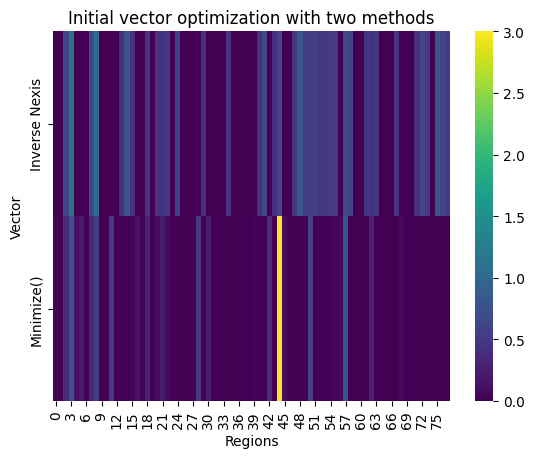

In [48]:
# Set all negative values in x0_inverse to 0
x0_inverse[x0_inverse < 0] = 0

# Upload x0 from minimize() method (check that thresholds and RIDS match for both methods)
x0_minimize = pandas.read_csv('minimize() initial vector.csv')
x0_minimize = x0_minimize.iloc[:, 1].values

#Calculate MSE
mse = mse_matrix(x0_inverse,x0_minimize)
print('MSE: ' + str(mse))

# Create a heatmap comparing to x0 vector methods
sns.heatmap([x0_inverse,x0_minimize], cmap='viridis',yticklabels=['Inverse Nexis', 'Minimize()'], vmin=0, vmax=3)

# Add labels and title
plt.xlabel('Regions')
plt.ylabel('Vector')
plt.title('Initial vector optimization with two methods')

Sparcity: 1.861774043607209


Text(0.5, 1.0, 'Initial vector optimization with Inverse Nexis')

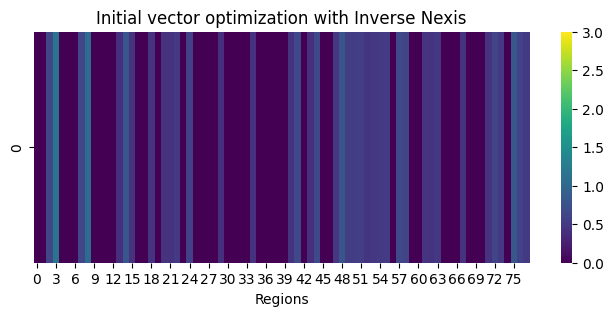

In [50]:
# Calculate sparcity
l2_norm = np.linalg.norm(x0_inverse, ord=2)
# Calculate the 75th percentile value
percentile_75th = np.percentile(x0_inverse, 75)
# Get the values in the vector that are below the 75th percentile
lower_75th_values = x0_inverse[x0_inverse < percentile_75th]
l2_norm_lower = np.linalg.norm(lower_75th_values, ord=2)
sparcity = l2_norm / l2_norm_lower
print('Sparcity: ' + str(sparcity))

# Create a heatmap for just Nexis inverse
plt.figure(figsize=(8, 3)) 
sns.heatmap([x0_inverse], cmap='viridis', vmin=0, vmax=3)

# Add labels and title
plt.xlabel('Regions')
plt.title('Initial vector optimization with Inverse Nexis')

## Loop through all subjects

In [70]:
# Avoid repeating any RIDS
unique_rids = subject_data['RID'].unique()

#Create a data frame for all patients seeding patterns
column_names = ['RID','ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate',	'ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal',	'ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala',	'Right-VentralDC']
seeding_all = pandas.DataFrame(columns=column_names)

for rid in unique_rids:

    patient = subject_data[subject_data['RID'] == rid] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]

    # Define patient tau data
    patient_tau = patient.iloc[:,3:]

    # Reorder regions to match region order of connectivity matrix
    patient_tau = patient_tau.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    patient_tau = patient_tau.drop(regions_to_exclude, axis = 1)

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

    # Perform the optimization
    custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau)

    result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B', 
                    options={'ftol': 1e-6, 'gtol': 1e-6})
    
    if result.success:
        optimized_initial_vec = result.x
        optimized_initial_vec = optimized_initial_vec.tolist( )
    
    # Create data frame for the subject
    seeding = pandas.DataFrame([[rid] + optimized_initial_vec], columns=column_names)

    # Concatenate the original DataFrame with the new DataFrame
    seeding_all = pandas.concat([seeding_all, seeding], ignore_index=True)

seeding_all

NameError: name 'Nexis_MSE' is not defined

In [42]:
# Save to a csv 
seeding_all.to_csv('Seeding patterns.csv')